## AdaGrad with Gradient Differences

Standard AdaGrad accumulates the sum of squares of past gradients, which is used to adjust the learning rate:
$$
\begin{aligned}
& G_t=\sum_{i=1}^t g_i^2 \\
& \theta_{t+1}=\theta_t-\frac{\eta}{\sqrt{G_t+\epsilon}} \cdot g_t
\end{aligned}
$$

Modified AdaGrad with gradient differences accumulates the sum of squares of differences between successive gradients:
$$
\begin{aligned}
& D_t=\sum_{i=1}^t\left(\Delta g_i\right)^2
& \text{where} \; \Delta g_i=g_i-g_{i-1} \\
& \theta_{t+1}=\theta_t-\frac{\eta}{\sqrt{D_t+\epsilon}} \cdot g_t
\end{aligned}
$$


In [1]:
import math
import torch
from torch.optim import Optimizer

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import time
import matplotlib.pyplot as plt

In [2]:
class AdaGradWithDiff(Optimizer):
    """
    AdaGrad optimizer with gradient differences for stepsize calculation.
    """
    def __init__(self, params, lr=1e-2, eps=1e-8):
        """
        Initializes the optimizer with hyperparameters.

        Args:
            params (iterable): Iterable of parameters to optimize.
            lr (float, optional): Learning rate. Defaults to 1e-2.
            eps (float, optional): Epsilon for numerical stability. Defaults to 1e-8.
        """
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))

        defaults = dict(lr=lr, eps=eps)
        super(AdaGradWithDiff, self).__init__(params, defaults)

        # State initialization
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0                                   # Steps for optimization
                state['sum_grad_diffs'] = torch.zeros_like(p.data)  # Sum of gradient difference
                state['prev_grad'] = torch.zeros_like(p.data)       # Previous gradient

    def __setstate__(self, state):
        super(AdaGradWithDiff, self).__setstate__(state)

    def step(self, closure=None):
        """
        Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss. Defaults to None.

        Returns:
            Optional[Tensor]: None if closure is None, otherwise
                the closure return value.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('AdaGradWithDiff does not support sparse gradients, please consider other optimizers.')

                state = self.state[p]

                state['step'] += 1
                sum_grad_diffs, prev_grad = state['sum_grad_diffs'], state['prev_grad']
                lr, eps = group['lr'], group['eps']

                grad_diff = abs(prev_grad - grad)

                sum_grad_diffs.addcmul_(grad_diff, grad_diff)
                denom = sum_grad_diffs.add_(eps).sqrt()

                p.data.addcdiv_(-lr, grad, denom)

                # At the end, change previous gradient to current gradient
                state['prev_grad'] = grad.clone()

        return loss

## Adam with Gradient Differences


Standard Adam accumulates the sum of squares of past gradients, which is used to adjust the learning rate:
\begin{align*}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t, \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2, \\
\hat{m_t} &= \frac{m_t}{1 - \beta_1^t}, \\
\hat{v_t} &= \frac{v_t}{1 - \beta_2^t}, \\
\theta_t &= \theta_{t-1} - \alpha \cdot \frac{\hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon},
\end{align*}

Modified Adam with gradient differences accumulates the sum of squares of differences between successive gradients:
$$
\begin{aligned}
D_t &= \sum_{i=1}^t\left(\Delta g_i\right)^2
& \text{where} \; \Delta g_i=g_i-g_{i-1} \\
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t, \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) D_t^2, \\
\hat{m_t} &= \frac{m_t}{1 - \beta_1^t}, \\
\hat{v_t} &= \frac{v_t}{1 - \beta_2^t}, \\
\theta_t &= \theta_{t-1} - \alpha \cdot \frac{\hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon},
\end{aligned}
$$


In [3]:
class AdamWithDiff(Optimizer):
    """
    Adam optimizer with gradient differences for stepsize calculation.
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, correct_bias=True):
        """
        Initializes the optimizer with hyperparameters.

        Args:
            params (iterable): Iterable of parameters to optimize.
            lr (float, optional): Learning rate. Defaults to 1e-3.
            betas (tuple, optional): Coefficients used for computing running averages
                of gradient and its square (default: (0.9, 0.999)).
            eps (float, optional): Epsilon for numerical stability. Defaults to 1e-8.
            amsgrad (bool, optional): Whether to use the AMSGrad variant. Defaults to False.
        """
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, correct_bias=correct_bias)
        super(AdamWithDiff, self).__init__(params, defaults)

        # State initialization
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0                               # Steps for optimization
                state['m'] = torch.zeros_like(p.data)      # Exponential moving average of gradient values
                state['v'] = torch.zeros_like(p.data)   # Exponential moving average of squared gradient values
                state['prev_grad'] = torch.zeros_like(p.data)   # Previous gradient

    def __setstate__(self, state):
        super(AdamWithDiff, self).__setstate__(state)

    def step(self, closure=None):
        """
        Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss. Defaults to None.

        Returns:
            Optional[Tensor]: None if closure is None, otherwise
                the closure return value.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('AdamWithDiff does not support sparse gradients, please consider other optimizers.')

                state = self.state[p]

                state['step'] += 1
                m, v, prev_grad, = state['m'], state['v'], state['prev_grad']
                beta1, beta2 = group['betas']
                lr, eps = group['lr'], group['eps']

                # Just adding the square of the weights to the loss function is *not*
                # the correct way of using L2 regularization/weight decay with Adam,
                # since that will interact with the m and v parameters in strange ways.
                #
                # Instead we want to decay the weights in a manner that doesn't interact
                # with the m/v parameters. This is equivalent to adding the square
                # of the weights to the loss with plain (non-momentum) SGD.
                # Add weight decay at the end (fixed version)
                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                grad_diff = abs(grad - prev_grad)

                m.mul_(beta1).add_(1 - beta1, grad)
                v.mul_(beta2).addcmul_(1 - beta2, grad_diff, grad_diff)
                denom = v.add_(group['eps']).sqrt()

                step_size = lr
                if group['correct_bias']:
                    bias_correction1 = 1 - beta1 ** state['step']
                    bias_correction2 = 1 - beta2 ** state['step']
                    step_size = lr * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, m, denom)

                # At the end, change previous gradient to current gradient
                state['prev_grad'] = grad.clone()

        return loss

In [15]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Define the Logistic Regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        out = self.linear(x)
        return out

# Function to load MNIST dataset and create DataLoader
def load_mnist(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Function to train the model with timing measurement
def train(model, optimizer, criterion, train_loader, num_epochs):
    epoch_times = []
    losses = []
    total_time_start = time.time()

    model.train()
    for epoch in range(num_epochs):
        epoch_start = time.time()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_end = time.time()

        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)

        epoch_time = epoch_end - epoch_start
        epoch_times.append(epoch_time)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {epoch_time:.2f} s')

    total_time_end = time.time()
    total_training_time = total_time_end - total_time_start
    print(f'Total training time: {total_training_time:.2f} s')

    return losses, epoch_times, total_training_time

# Function to evaluate the model with timing measurement
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    eval_start = time.time()

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    eval_end = time.time()
    eval_time = eval_end - eval_start

    accuracy = correct / total * 100
    print(f'Accuracy on the test set: {accuracy:.2f}%, Evaluation time: {eval_time:.2f} s')

    return accuracy, eval_time

In [16]:
# Define constants
input_size = 28 * 28  # MNIST image size is 28x28
num_classes = 10  # 10 digits (0-9)
batch_size = 64
learning_rate = 0.001
num_epochs = 20

# Load MNIST data
train_loader, test_loader = load_mnist(batch_size)

# Initialize models
model_standard = LogisticRegression(input_size, num_classes)
model_custom = LogisticRegression(input_size, num_classes)

# Define criteria and optimizers
criterion = nn.CrossEntropyLoss()

optimizer_standard = optim.Adam(model_standard.parameters(), lr=learning_rate)
optimizer_custom = AdamWithDiff(model_custom.parameters(), lr=learning_rate)

# Train with standard Adam optimizer
print("\nTraining with Standard Adam Optimizer:")
train_losses_standard, epoch_times_standard, convergence_time_standard = train(model_standard, optimizer_standard, criterion, train_loader, num_epochs)

# Evaluate with standard Adam optimizer
test_accuracy_standard, eval_time_standard = evaluate(model_standard, test_loader)

# Train with custom AdamWithDiff optimizer
print("\nTraining with Custom AdamWithDiff Optimizer:")
train_losses_custom, epoch_times_custom, convergence_time_custom = train(model_custom, optimizer_custom, criterion, train_loader, num_epochs)

# Evaluate with custom AdamWithDiff optimizer
test_accuracy_custom, eval_time_custom = evaluate(model_custom, test_loader)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8157402.56it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1621281.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13696353.25it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2239921.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


Training with Standard Adam Optimizer:
Epoch [1/20], Loss: 0.4696, Time: 11.38 s
Epoch [2/20], Loss: 0.3266, Time: 10.97 s
Epoch [3/20], Loss: 0.3100, Time: 10.87 s
Epoch [4/20], Loss: 0.3022, Time: 10.54 s
Epoch [5/20], Loss: 0.2950, Time: 10.86 s
Epoch [6/20], Loss: 0.2901, Time: 11.12 s
Epoch [7/20], Loss: 0.2870, Time: 10.91 s
Epoch [8/20], Loss: 0.2851, Time: 11.24 s
Epoch [9/20], Loss: 0.2821, Time: 11.74 s
Epoch [10/20], Loss: 0.2809, Time: 10.97 s
Epoch [11/20], Loss: 0.2775, Time: 10.81 s
Epoch [12/20], Loss: 0.2765, Time: 10.96 s
Epoch [13/20], Loss: 0.2750, Time: 11.15 s
Epoch [14/20], Loss: 0.2731, Time: 11.64 s
Epoch [15/20], Loss: 0.2740, Time: 13.10 s
Epoch [16/20], Loss: 0.2721, Time: 12.28 s
Epoch [17/20], Loss: 0.2715, Time: 11.65 s
Epoch [18/20], Loss: 0.2696, Time: 11.83 s
Epoch [19/20], Loss: 0.2671, Time: 10.90 s
Epoch [20/20], Loss: 0.2685, Time: 11.04 s
Total training time: 225.98 s
Accu

<ipython-input-14-d20f7204b50b>:86: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1578.)
  m.mul_(beta1).add_(1 - beta1, grad)


Epoch [1/20], Loss: 0.4665, Time: 14.00 s
Epoch [2/20], Loss: 0.3283, Time: 11.67 s
Epoch [3/20], Loss: 0.3103, Time: 11.44 s
Epoch [4/20], Loss: 0.2990, Time: 11.35 s
Epoch [5/20], Loss: 0.2929, Time: 12.81 s
Epoch [6/20], Loss: 0.2909, Time: 11.54 s
Epoch [7/20], Loss: 0.2856, Time: 11.43 s
Epoch [8/20], Loss: 0.2806, Time: 11.55 s
Epoch [9/20], Loss: 0.2796, Time: 11.67 s
Epoch [10/20], Loss: 0.2781, Time: 11.59 s
Epoch [11/20], Loss: 0.2764, Time: 11.72 s
Epoch [12/20], Loss: 0.2741, Time: 12.77 s
Epoch [13/20], Loss: 0.2723, Time: 14.32 s
Epoch [14/20], Loss: 0.2716, Time: 14.87 s
Epoch [15/20], Loss: 0.2710, Time: 12.20 s
Epoch [16/20], Loss: 0.2687, Time: 11.55 s
Epoch [17/20], Loss: 0.2672, Time: 12.03 s
Epoch [18/20], Loss: 0.2667, Time: 12.29 s
Epoch [19/20], Loss: 0.2667, Time: 11.75 s
Epoch [20/20], Loss: 0.2651, Time: 11.77 s
Total training time: 244.33 s
Accuracy on the test set: 92.15%, Evaluation time: 2.57 s


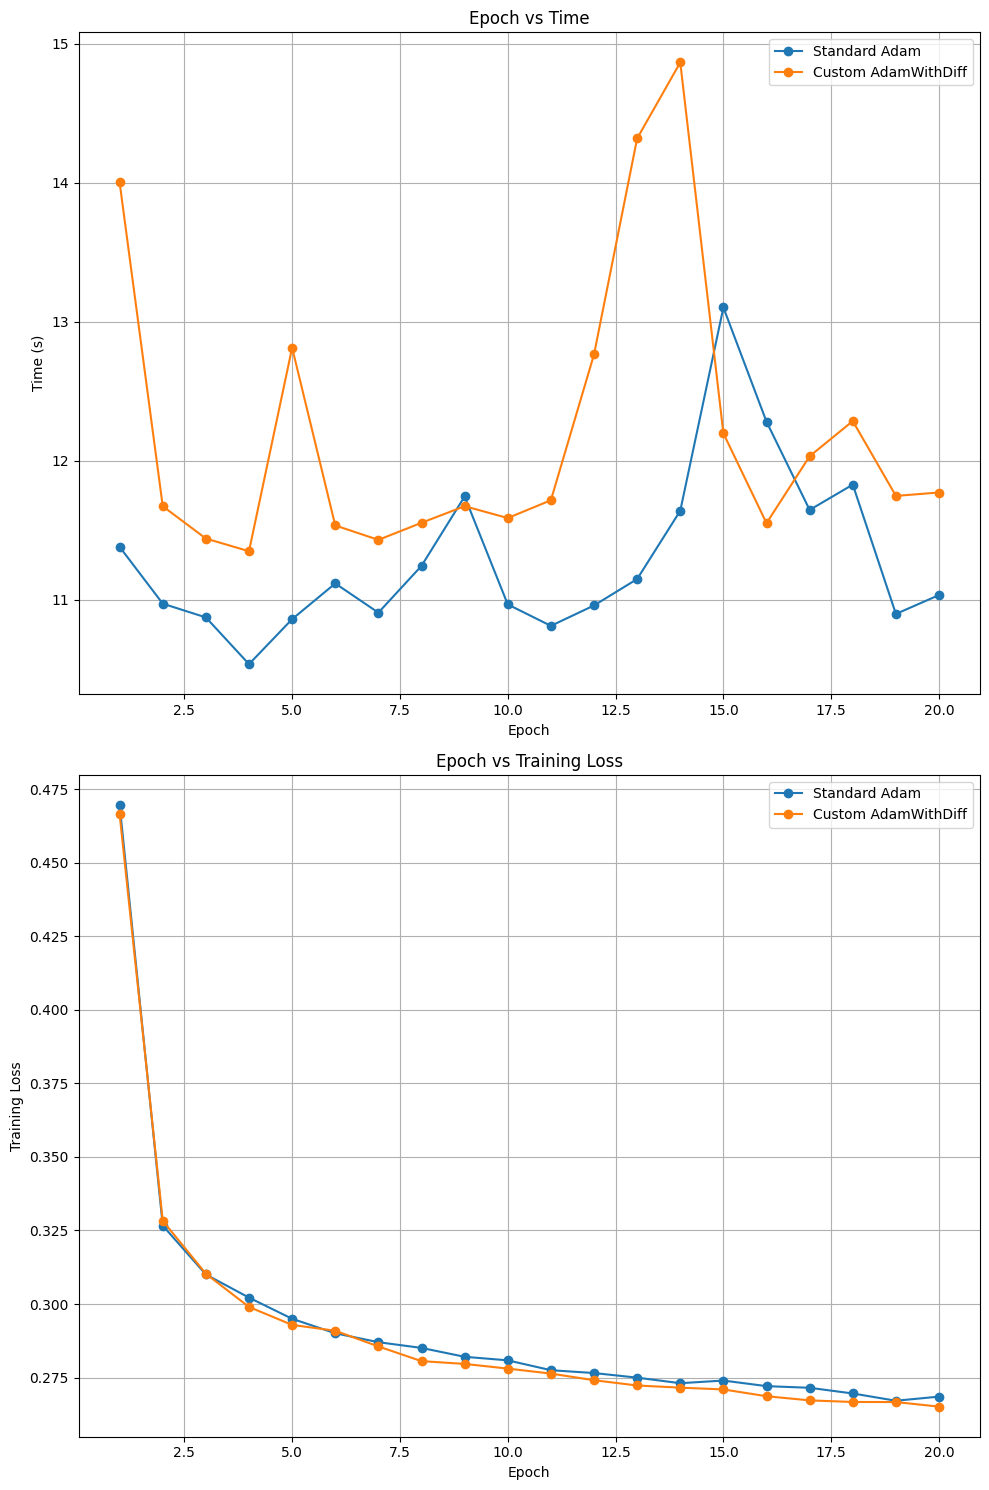


Convergence Time:
Standard Adam: 225.98 s
Custom AdamWithDiff: 244.33 s


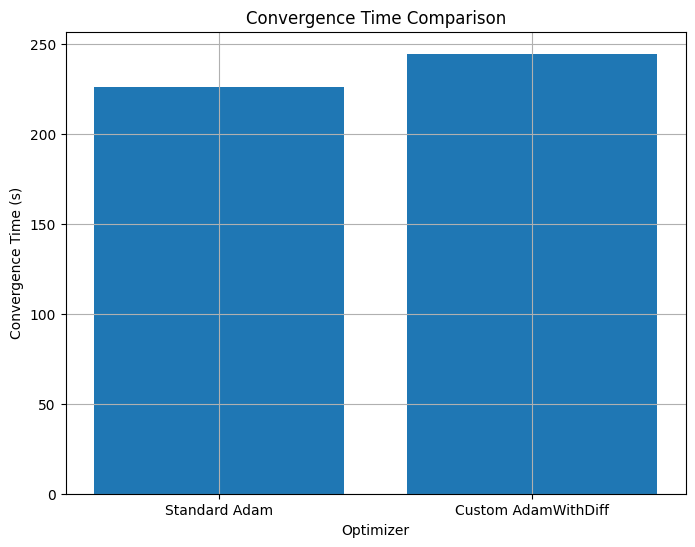

In [17]:
# Plot epoch vs time
plt.figure(figsize=(10, 15))

plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), epoch_times_standard, 'o-', label='Standard Adam')
plt.plot(range(1, num_epochs + 1), epoch_times_custom, 'o-', label='Custom AdamWithDiff')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.title('Epoch vs Time')
plt.legend()
plt.grid(True)

# Plot epoch vs train loss
plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), train_losses_standard, 'o-', label='Standard Adam')
plt.plot(range(1, num_epochs + 1), train_losses_custom, 'o-', label='Custom AdamWithDiff')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Epoch vs Training Loss')
plt.legend()
plt.grid(True)

# Plot epoch vs test accuracy
# plt.subplot(3, 1, 3)
# plt.plot(range(1, num_epochs + 1), [test_accuracy_standard] * num_epochs, label='Standard Adam')
# plt.plot(range(1, num_epochs + 1), [test_accuracy_custom] * num_epochs, label='Custom AdamWithDiff')
# plt.xlabel('Epoch')
# plt.ylabel('Test Accuracy (%)')
# plt.title('Epoch vs Test Accuracy')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()

# Print and plot convergence time
print(f'\nConvergence Time:')
print(f'Standard Adam: {convergence_time_standard:.2f} s')
print(f'Custom AdamWithDiff: {convergence_time_custom:.2f} s')

plt.figure(figsize=(8, 6))
plt.bar(['Standard Adam', 'Custom AdamWithDiff'], [convergence_time_standard, convergence_time_custom])
plt.xlabel('Optimizer')
plt.ylabel('Convergence Time (s)')
plt.title('Convergence Time Comparison')
plt.grid(True)
plt.show()

In [18]:
# Define constants
input_size = 28 * 28  # MNIST image size is 28x28
num_classes = 10  # 10 digits (0-9)
batch_size = 64
learning_rate = 0.001
num_epochs = 20

# Load MNIST data
train_loader, test_loader = load_mnist(batch_size)

# Initialize models
model_standard = LogisticRegression(input_size, num_classes)
model_custom = LogisticRegression(input_size, num_classes)

# Define criteria and optimizers
criterion = nn.CrossEntropyLoss()

optimizer_standard = optim.Adagrad(model_standard.parameters(), lr=learning_rate)
optimizer_custom = AdaGradWithDiff(model_custom.parameters(), lr=learning_rate)

# Train with standard Adagrad optimizer
print("\nTraining with Standard Adagrad Optimizer:")
train_losses_standard, epoch_times_standard, convergence_time_standard = train(model_standard, optimizer_standard, criterion, train_loader, num_epochs)

# Evaluate with standard Adagrad optimizer
test_accuracy_standard, eval_time_standard = evaluate(model_standard, test_loader)

# Train with custom AdaGradWithDiff optimizer
print("\nTraining with Custom AdaGradWithDiff Optimizer:")
train_losses_custom, epoch_times_custom, convergence_time_custom = train(model_custom, optimizer_custom, criterion, train_loader, num_epochs)

# Evaluate with custom AdaGradWithDiff optimizer
test_accuracy_custom, eval_time_custom = evaluate(model_custom, test_loader)


Training with Standard Adagrad Optimizer:
Epoch [1/20], Loss: 1.0322, Time: 11.81 s
Epoch [2/20], Loss: 0.6855, Time: 11.90 s
Epoch [3/20], Loss: 0.5976, Time: 12.61 s
Epoch [4/20], Loss: 0.5504, Time: 12.12 s
Epoch [5/20], Loss: 0.5198, Time: 12.03 s
Epoch [6/20], Loss: 0.4979, Time: 14.50 s
Epoch [7/20], Loss: 0.4811, Time: 13.14 s
Epoch [8/20], Loss: 0.4678, Time: 12.69 s
Epoch [9/20], Loss: 0.4568, Time: 12.74 s
Epoch [10/20], Loss: 0.4475, Time: 12.41 s
Epoch [11/20], Loss: 0.4397, Time: 11.94 s
Epoch [12/20], Loss: 0.4328, Time: 12.17 s
Epoch [13/20], Loss: 0.4268, Time: 12.94 s
Epoch [14/20], Loss: 0.4214, Time: 12.75 s
Epoch [15/20], Loss: 0.4165, Time: 11.73 s
Epoch [16/20], Loss: 0.4121, Time: 12.04 s
Epoch [17/20], Loss: 0.4082, Time: 11.93 s
Epoch [18/20], Loss: 0.4046, Time: 11.98 s
Epoch [19/20], Loss: 0.4012, Time: 12.30 s
Epoch [20/20], Loss: 0.3981, Time: 12.02 s
Total training time: 247.75 s
Accuracy on the test set: 89.99%, Evaluation time: 1.76 s

Training with Cus

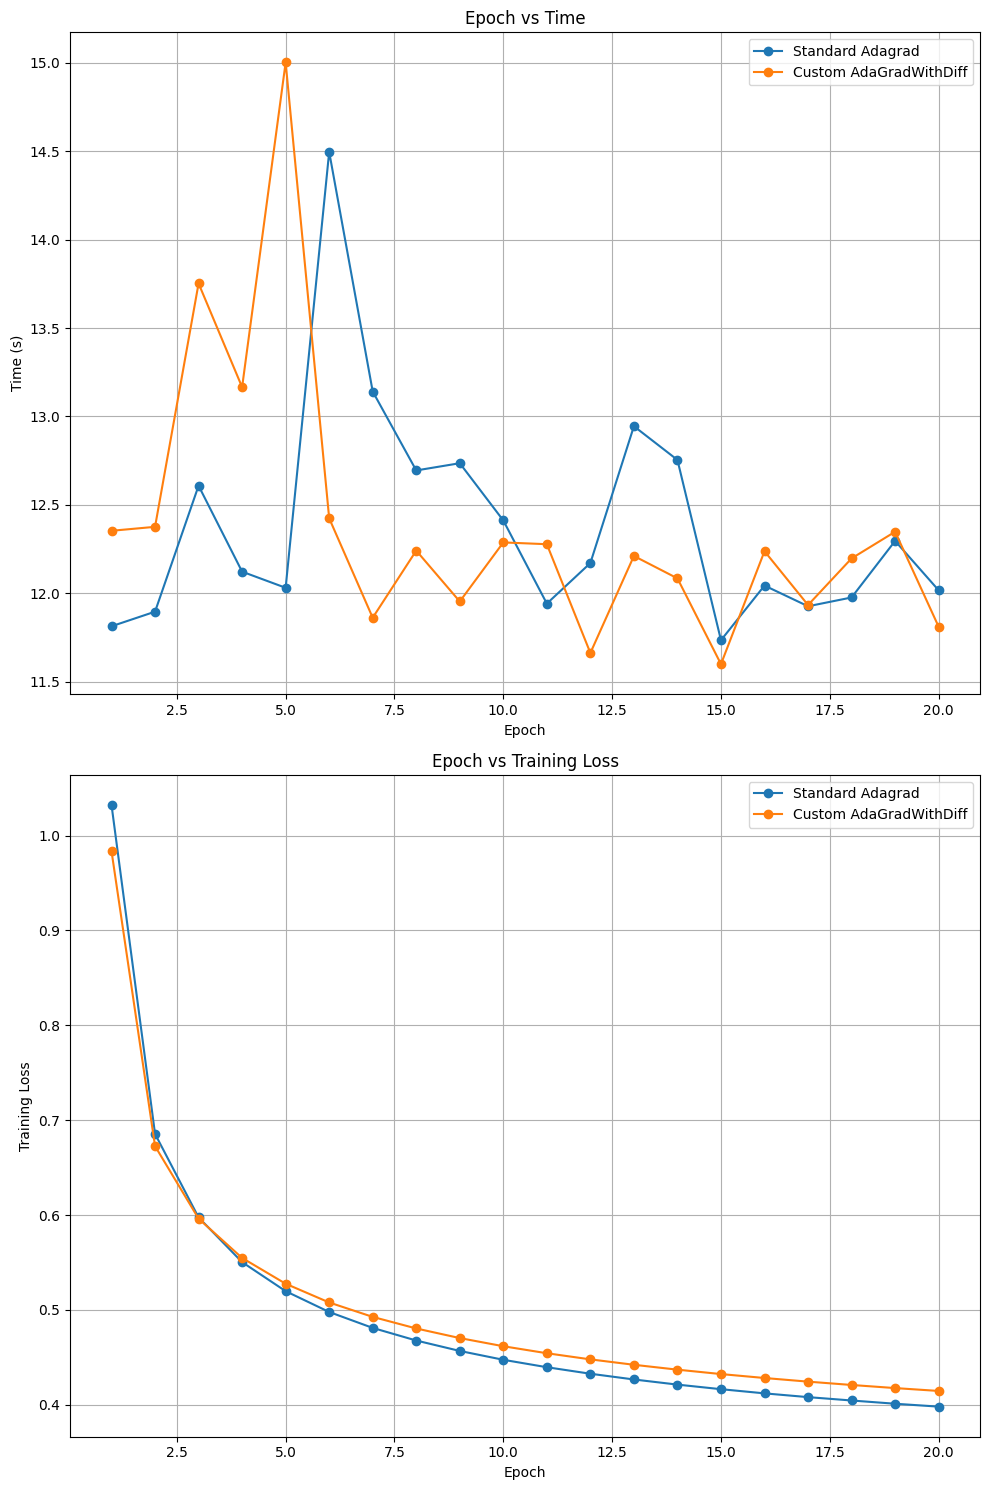


Convergence Time:
Standard Adagrad: 247.75 s
Custom AdaGradWithDiff: 247.78 s


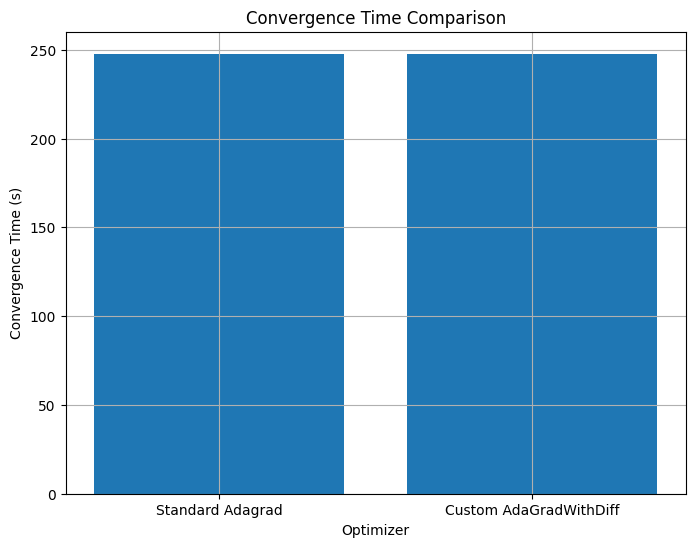

In [19]:
# Plot epoch vs time
plt.figure(figsize=(10, 15))

plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), epoch_times_standard, 'o-', label='Standard Adagrad')
plt.plot(range(1, num_epochs + 1), epoch_times_custom, 'o-', label='Custom AdaGradWithDiff')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.title('Epoch vs Time')
plt.legend()
plt.grid(True)

# Plot epoch vs train loss
plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), train_losses_standard, 'o-', label='Standard Adagrad')
plt.plot(range(1, num_epochs + 1), train_losses_custom, 'o-', label='Custom AdaGradWithDiff')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Epoch vs Training Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print and plot convergence time
print(f'\nConvergence Time:')
print(f'Standard Adagrad: {convergence_time_standard:.2f} s')
print(f'Custom AdaGradWithDiff: {convergence_time_custom:.2f} s')

plt.figure(figsize=(8, 6))
plt.bar(['Standard Adagrad', 'Custom AdaGradWithDiff'], [convergence_time_standard, convergence_time_custom])
plt.xlabel('Optimizer')
plt.ylabel('Convergence Time (s)')
plt.title('Convergence Time Comparison')
plt.grid(True)
plt.show()

### Testing on simple functions.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math
# from mpl_toolkits.mplot3d import Axes3D

# %matplotlib widget

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [6]:
# parameters
NO_ITERS = 50
LR_RATE = 0.1
BETA1 = 0.95
BETA2 = 0.999
EPS = 0.00000001

In [5]:
class AdaGrad(object):
    def __init__(self, lr, eps):
        self.lr = lr
        self.eps = eps
        self.t = 0

    def update(self, x, g):
        self.t += 1
        x_t = x - (self.lr * g) / np.sqrt(g ** 2 + self.eps)
        return x_t

class AdaGradWithDiff_v1(object):
    def __init__(self, lr, eps):
        self.lr = lr
        self.eps = eps
        self.t = 0
        self.prev_g = 0.0

    def update(self, x, g):
        self.t +=1
        diff_g = np.abs(g - self.prev_g)
        x_t = x - (self.lr * g) / np.sqrt(diff_g ** 2 + self.eps)
        self.prev_g = g
        return x_t

In [7]:
class Adam(object):
    def __init__(self, lr, beta1, beta2, eps):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = 0.0 # 1st order
        self.v = 0.0 # 2nd order

    def update(self, x, g):
        self.t += 1
        self.m = self.beta1 * self.m + (1.0 - self.beta1) * g
        self.v = self.beta2 * self.v + (1.0 - self.beta2) * g ** 2
        m_adj = self.m / (1.0 - np.power(self.beta1, self.t))
        v_adj = self.v / (1.0 - np.power(self.beta2, self.t))
        x_t = x - self.lr * m_adj / np.sqrt(v_adj + self.eps)
        return x_t

class AdamWithDiff_v1(object):
    def __init__(self, lr, beta1, beta2, eps):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = 0.0 # 1st order
        self.v = 0.0 # 2nd order
        self.prev_g = 0.0

    def update(self, x, g):
        self.t += 1
        diff_g = np.abs(g - self.prev_g)
        self.m = self.beta1 * self.m + (1.0 - self.beta1) * g
        self.v = self.beta2 * self.v + (1.0 - self.beta2) * diff_g ** 2
        m_adj = self.m / (1.0 - np.power(self.beta1, self.t))
        v_adj = self.v / (1.0 - np.power(self.beta2, self.t))
        x_t = x - self.lr * m_adj / (np.sqrt(v_adj) + self.eps)
        self.prev_g = g
        return x_t

In [8]:
# Functions and their gradients
def fun1(x):
    if x <= 0:
        return (x + 0.3)*(x + 0.3)
    else:
        return (x - 0.2)*(x - 0.2) + 0.05

def calc_grad_fun1(x):
    if x <= 0:
        return 2*x + 0.6
    else:
        return 2*x - 0.4

def fun2(x):
    if x <= -0.9:
        return -40 * x - 35
    else:
        C2 = 1 - (-0.9 * math.sin(8) / 8) + (math.cos(8) / 8) + 0.729
        return (x * math.sin(8 * x) / 8) - ( math.cos(8 * x) / 8) + x**3 + C2

def calc_grad_fun2(x):
    if x <= -0.9:
        return -40
    else:
        return x * math.cos(8 * x) + math.sin(8 * x) + 3 * x * x

def fun3(x):
    if x <= -0.5:
        return x**2
    elif x <= -0.4:
        return x + 0.75
    elif x <= 0:
        return -7/8 * x
    elif x <= 0.4:
        return 7/8 * x
    elif x <= 0.5:
        return -x + 0.75
    else:
        return x**2

def calc_grad_fun3(x):
    if x <= -0.5:
        return 2 * x
    elif x <= -0.4:
        return 1.0
    elif x <= 0.0:
        return -7/8
    elif x <= 0.4:
        return 7/8
    elif x <= 0.5:
        return -1.0
    else:
        return 2 * x

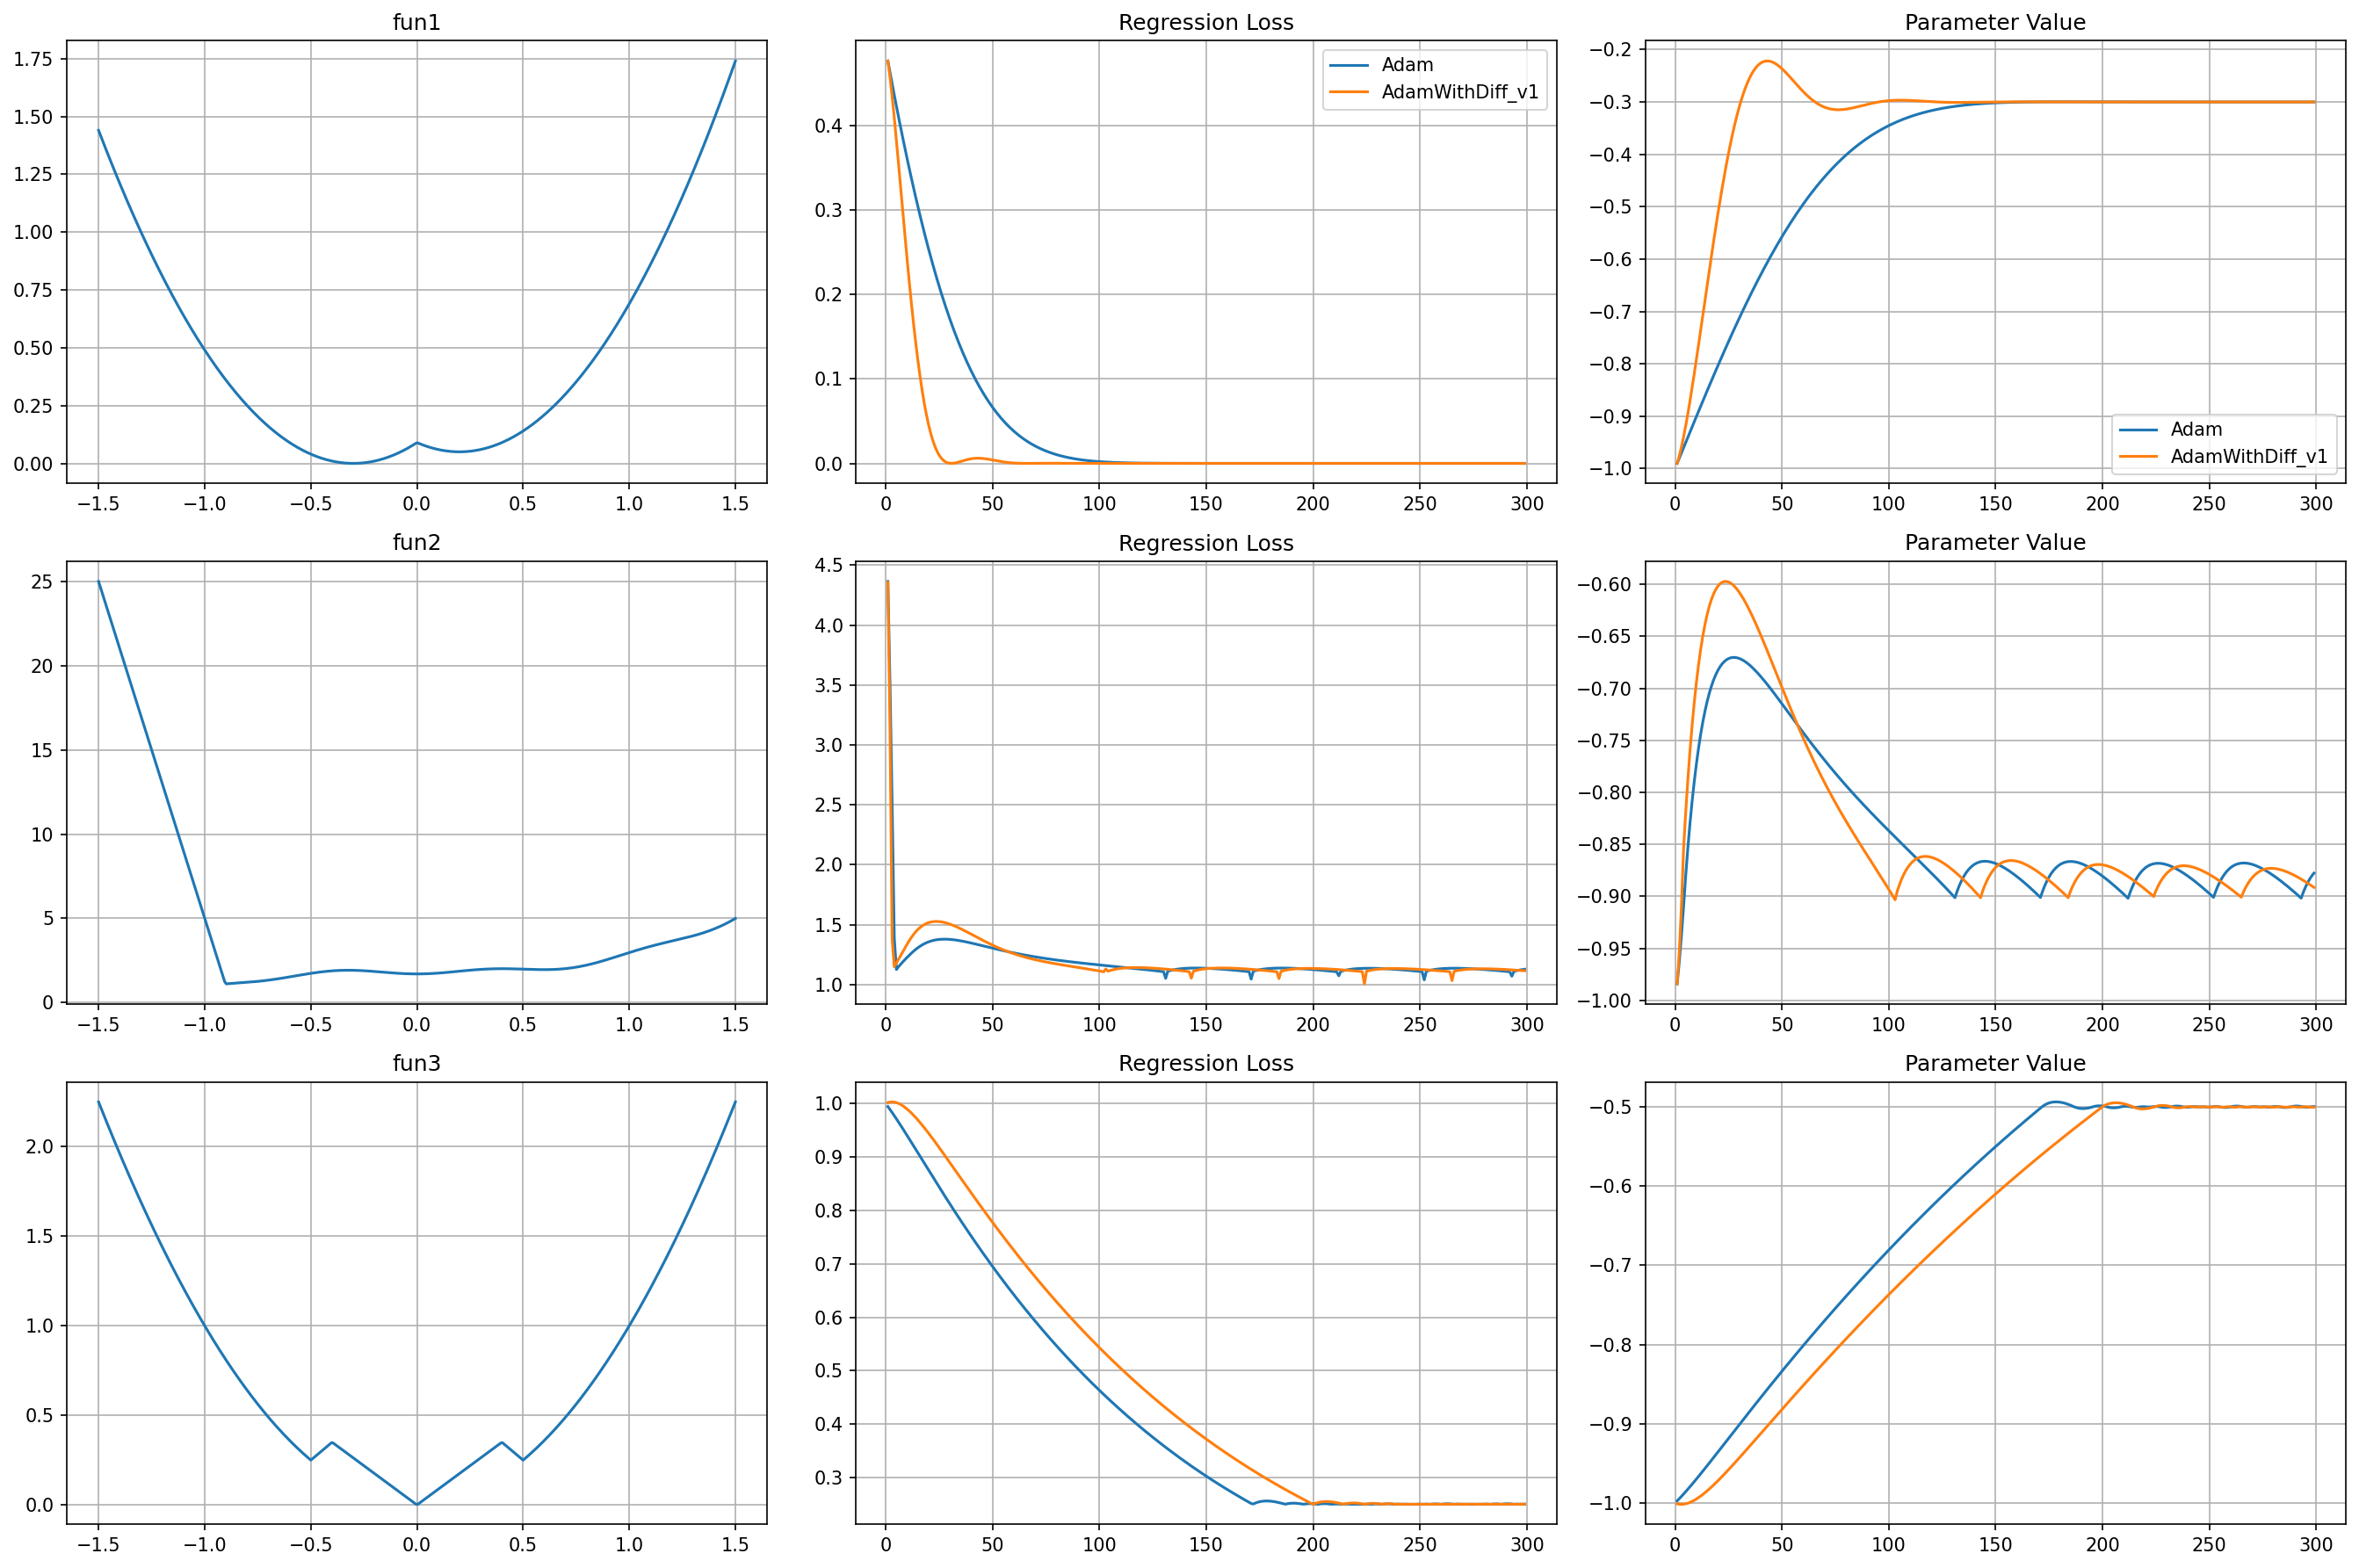

In [37]:
# Solve function
def solve(fun, calc_grad, x0, solver, nb_iters):
    x = np.zeros(nb_iters)
    y = np.zeros(nb_iters)
    grad_norm = np.zeros(nb_iters)
    grad_diff = np.zeros(nb_iters)
    prev_grad = 0
    x[0] = x0
    for idx_iter in range(1, nb_iters):
        g = calc_grad(x[idx_iter - 1])
        x[idx_iter] = solver.update(x[idx_iter - 1], g)
        y[idx_iter] = fun(x[idx_iter])
        grad_norm[idx_iter] = np.abs(g)
        grad_diff[idx_iter] = np.abs(g - prev_grad)
        prev_grad = g
    return x, y

def get_grads(fun, calc_grad, x0, nb_iters):
    x = np.zeros(nb_iters)
    grad_norm = np.zeros(nb_iters)
    grad_diff = np.zeros(nb_iters)
    prev_grad = 0
    x[0] = x0
    for idx_iter in range(1, nb_iters):
        g = calc_grad(x[idx_iter - 1])
        grad_norm[idx_iter] = np.abs(g)
        grad_diff[idx_iter] = np.abs(g - prev_grad)
        prev_grad = g
    return grad_norm, grad_diff

# Parameters
lrn_rate = 0.01
beta1 = 0.9
beta2 = 0.999
eps = 1e-8
nb_iters = 300

# Initial point
x0 = -1.0

# Functions and their gradients
functions = [(fun1, calc_grad_fun1, 'fun1'), (fun2, calc_grad_fun2, 'fun2'), (fun3, calc_grad_fun3, 'fun3')]

# Optimizers
optimizers = [
    # ('AdaGrad', AdaGrad(lrn_rate, eps)),
    # ('AdaGradWithDiff_v1', AdaGradWithDiff_v1(lrn_rate, eps)),
    ('Adam', Adam(lrn_rate, beta1, beta2, eps)),
    ('AdamWithDiff_v1', AdamWithDiff_v1(lrn_rate, beta1, beta2, eps))
]

# Plotting
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = [18.0, 12.0]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for row, (fun, calc_grad, fun_name) in enumerate(functions):
    # Plot the function itself
    x_vals = np.linspace(-1.5, 1.5, 400)
    y_vals = np.array([fun(x) for x in x_vals])
    axes[row, 0].plot(x_vals, y_vals)
    axes[row, 0].set_title(f'{fun_name}')
    axes[row, 0].grid()

    for col, (opt_name, solver) in enumerate(optimizers):
        x, y = solve(fun, calc_grad, x0, solver, nb_iters)

        # Plot iteration vs regression loss
        axes[row, 1].plot(np.arange(nb_iters - 1) + 1, y[1:], label=f'{opt_name}')
        axes[row, 1].set_title(f'Regression Loss')

        # Plot iteration vs Parameter Value
        axes[row, 2].plot(np.arange(nb_iters - 1) + 1, x[1:], label=f'{opt_name}')
        axes[row, 2].set_title(f'Parameter Value')

    axes[row, 1].grid()
    axes[row, 2].grid()

# Add legends
for col in range(1, 3):
    axes[0, col].legend()

plt.tight_layout()
plt.show()

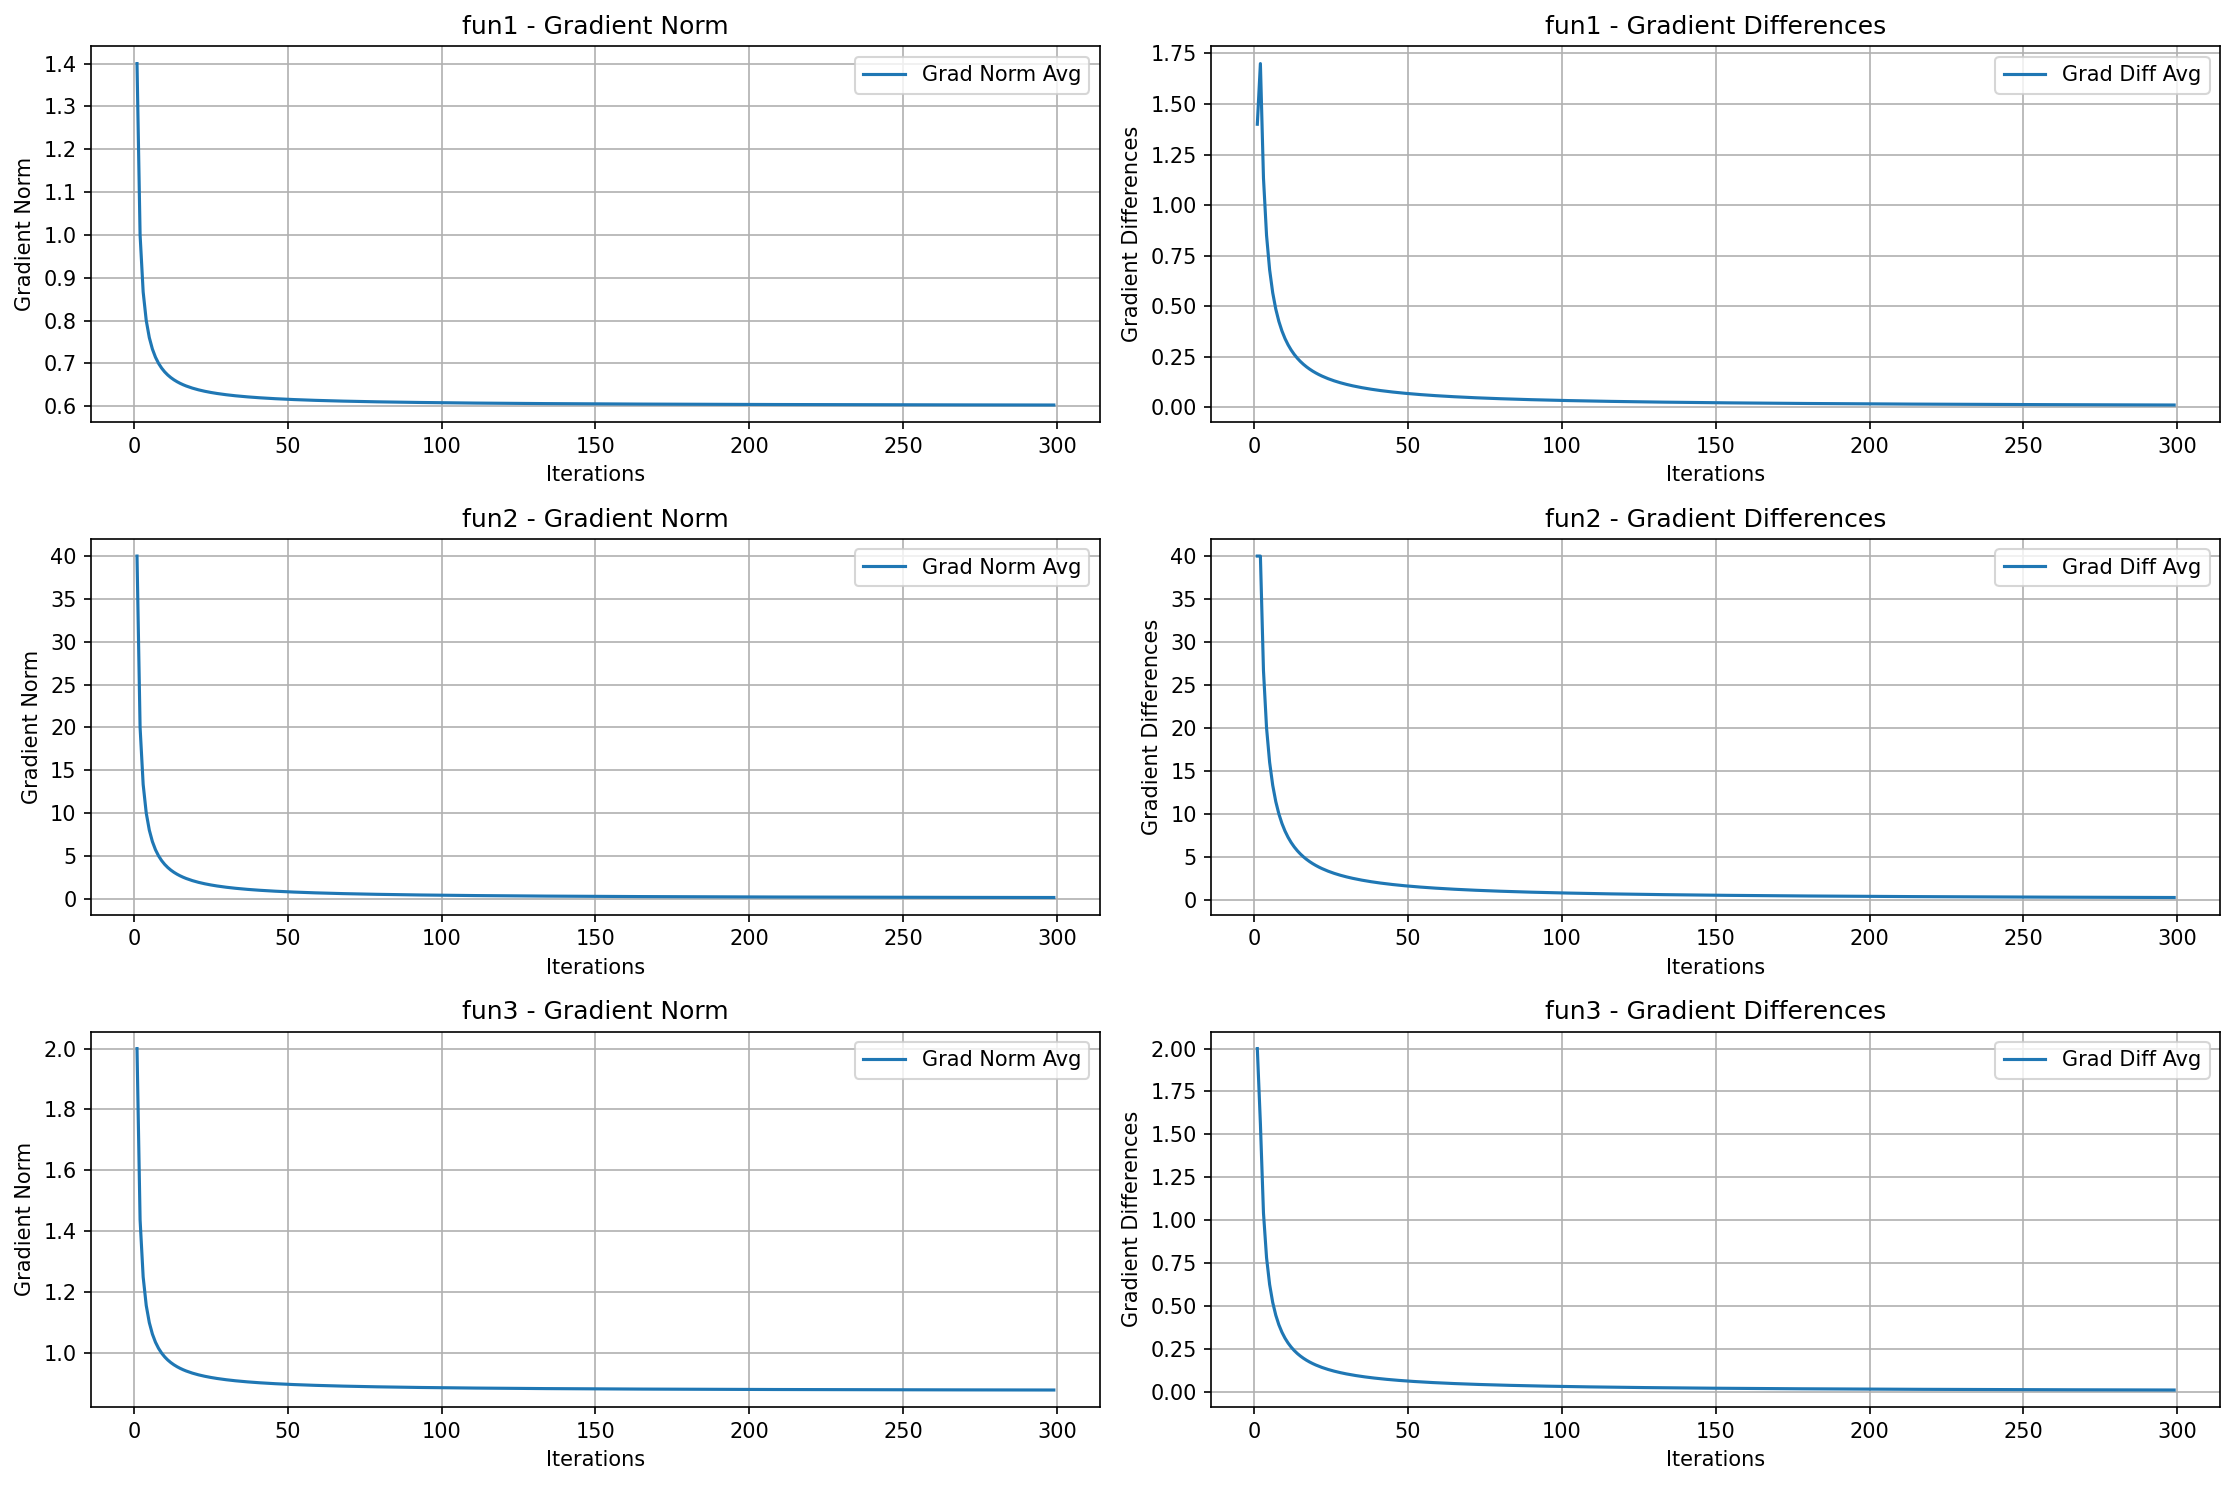

In [44]:
# Plotting
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = [15.0, 10.0]

fig, axes = plt.subplots(3, 2, figsize=(15, 10))

for row, (fun, calc_grad, fun_name) in enumerate(functions):
    grad_norm_data = []
    grad_diff_data = []

    grad_norm, grad_diff = get_grads(fun, calc_grad, x0, nb_iters)
    grad_norm_data.append((np.arange(nb_iters - 1) + 1, grad_norm[1:]))
    grad_diff_data.append((np.arange(nb_iters - 1) + 1, grad_diff[1:]))

    # Plot gradient norm
    for x_data, grad_norm in grad_norm_data:
        running_avg_norm = np.cumsum(grad_norm) / np.arange(1, nb_iters)
        # axes[row, 0].scatter(x_data, grad_norm, alpha=0.5, label='Grad Norm')
        axes[row, 0].plot(x_data, running_avg_norm, label=f'Grad Norm Avg')
    axes[row, 0].set_title(f'{fun_name} - Gradient Norm')
    axes[row, 0].set_xlabel('Iterations')
    axes[row, 0].set_ylabel('Gradient Norm')
    axes[row, 0].legend()
    axes[row, 0].grid()

    # Plot gradient differences
    for x_data, grad_diff in grad_diff_data:
        running_avg_diff = np.cumsum(grad_diff) / np.arange(1, nb_iters)
        # axes[row, 1].scatter(x_data, grad_diff, alpha=0.5, label='Grad Diff')
        axes[row, 1].plot(x_data, running_avg_diff, label=f'Grad Diff Avg')
    axes[row, 1].set_title(f'{fun_name} - Gradient Differences')
    axes[row, 1].set_xlabel('Iterations')
    axes[row, 1].set_ylabel('Gradient Differences')
    axes[row, 1].legend()
    axes[row, 1].grid()

plt.tight_layout()
plt.show()

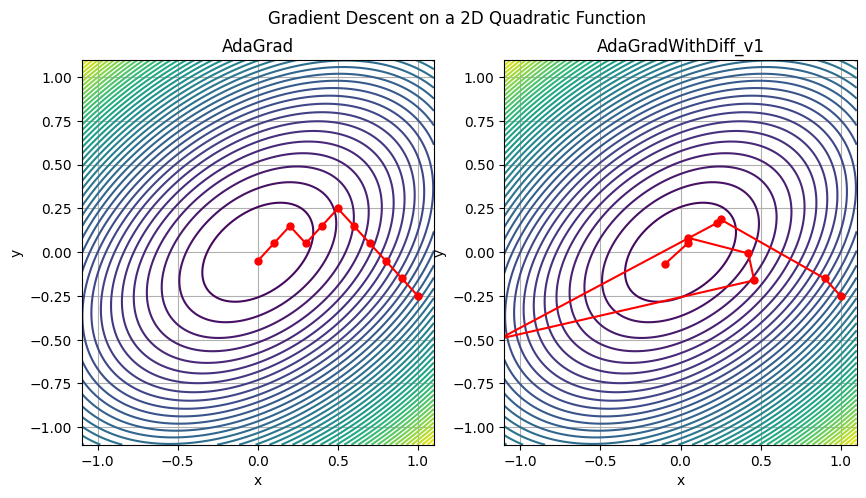

In [11]:
f = lambda x, y: 2*x**2 + 3*y**2 - 2*x*y - 1

# Define the derivative of f(x, y)
def df(x, y):
    return np.array([4*x - 2*y, 6*y - 2*x])

# Gradient descent function
def gradient_descent(optimizer, iterations, x0, y0):
    xs, ys = [x0], [y0]
    x, y = x0, y0
    for _ in range(iterations):
        grad = df(x, y)
        x, y = optimizer.update(np.array([x, y]), grad)
        xs.append(x)
        ys.append(y)
    return xs, ys

# Parameters
LR_RATE = 0.1
EPS = 1e-8
BETA1 = 0.95
BETA2 = 0.999
ITERATIONS = 10
x0, y0 = 1.0, -0.25

# Create optimizers
optimizers = {
    'AdaGrad': AdaGrad(LR_RATE, EPS),
    'AdaGradWithDiff_v1': AdaGradWithDiff_v1(LR_RATE, EPS),
}

# Perform gradient descent using both optimizers
results = {}
for name, optimizer in optimizers.items():
    results[name] = gradient_descent(optimizer, ITERATIONS, x0, y0)

# Create the contour plot
x = np.linspace(-1.1, 1.1, 400)
y = np.linspace(-1.1, 1.1, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Gradient Descent on a 2D Quadratic Function')

for ax, (name, (xs, ys)) in zip(axes, results.items()):
    ax.contour(X, Y, Z, levels=50, cmap='viridis')
    ax.plot(xs, ys, 'ro-', markersize=5)

    # Annotate the points with iteration numbers
    # for i, (x, y) in enumerate(zip(xs, ys)):
    #     ax.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color='black')

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_title(name)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)

plt.show()


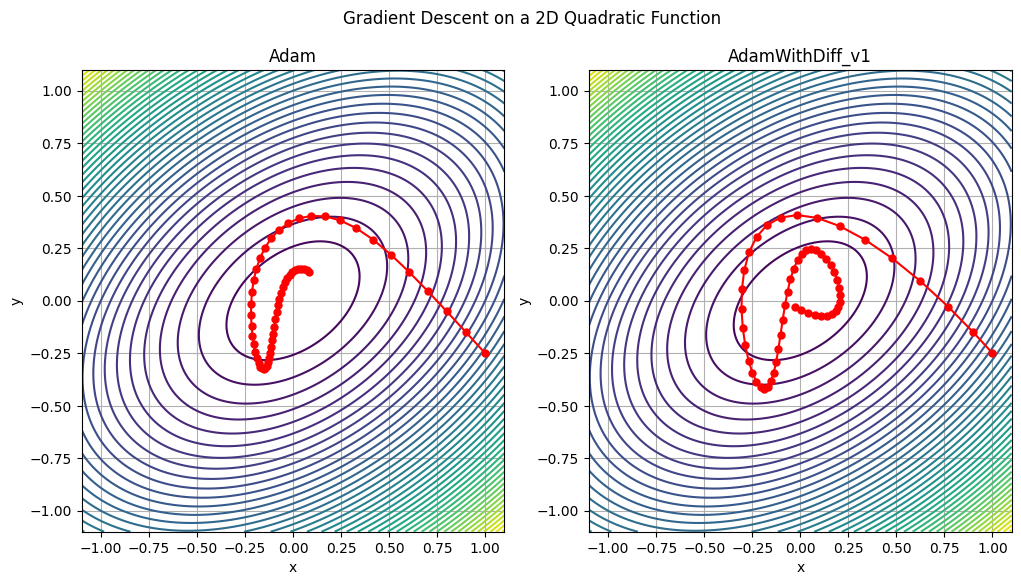

In [12]:
f = lambda x, y: 2*x**2 + 3*y**2 - 2*x*y - 1

# Define the derivative of f(x, y)
def df(x, y):
    return np.array([4*x - 2*y, 6*y - 2*x])

# Gradient descent function
def gradient_descent(optimizer, iterations, x0, y0):
    xs, ys = [x0], [y0]
    x, y = x0, y0
    for _ in range(iterations):
        grad = df(x, y)
        x, y = optimizer.update(np.array([x, y]), grad)
        xs.append(x)
        ys.append(y)
    return xs, ys

# Parameters
LR_RATE = 0.1
EPS = 1e-8
BETA1 = 0.95
BETA2 = 0.999
ITERATIONS = 55
x0, y0 = 1.0, -0.25

# Create optimizers
optimizers = {
    'Adam': Adam(LR_RATE, BETA1, BETA2, EPS),
    'AdamWithDiff_v1': AdamWithDiff_v1(LR_RATE, BETA1, BETA2, EPS)
}

# Perform gradient descent using both optimizers
results = {}
for name, optimizer in optimizers.items():
    results[name] = gradient_descent(optimizer, ITERATIONS, x0, y0)

# Create the contour plot
x = np.linspace(-1.1, 1.1, 400)
y = np.linspace(-1.1, 1.1, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Gradient Descent on a 2D Quadratic Function')

for ax, (name, (xs, ys)) in zip(axes, results.items()):
    ax.contour(X, Y, Z, levels=50, cmap='viridis')
    ax.plot(xs, ys, 'ro-', markersize=5)

    # Annotate the points with iteration numbers
    # for i, (x, y) in enumerate(zip(xs, ys)):
    #     ax.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color='black')

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_title(name)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)

plt.show()


### 3d plots

In [ ]:
# Define the 3D function and its gradient
def f(x, y, z):
    return x**2 + y**2 + z**2

def df(x, y, z):
    return np.array([2 * x, 2 * y, 2 * z])

# Gradient descent function
def gradient_descent(optimizer, iterations, x0, y0, z0):
    xs, ys, zs, fs = [x0], [y0], [z0], [f(x0, y0, z0)]
    x, y, z = x0, y0, z0
    for _ in range(iterations):
        grad = df(x, y, z)
        x, y, z = optimizer.update(np.array([x, y, z]), grad)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        fs.append(f(x, y, z))
    return xs, ys, zs, fs

# Parameters
LR_RATE = 0.1
EPS = 1e-8
ITERATIONS = 30
x0, y0, z0 = 1.0, 1.0, 1.0

# Create optimizers
optimizers = {
    'AdaGrad': AdaGrad(LR_RATE, EPS),
    'AdaGradWithDiff_v1': AdaGradWithDiff_v1(LR_RATE, EPS)
}

# Perform gradient descent using both optimizers
results = {}
for name, optimizer in optimizers.items():
    results[name] = gradient_descent(optimizer, ITERATIONS, x0, y0, z0)

# Create the 3D plot
fig = plt.figure(figsize=(14, 6))

# Create a grid of points for plotting the function surface
x = np.linspace(-1.1, 1.1, 100)
y = np.linspace(-1.1, 1.1, 100)
z = np.linspace(-1.1, 1.1, 100)
X, Y, Z = np.meshgrid(x, y, z)
F = f(X, Y, Z)

for i, (name, (xs, ys, zs, fs)) in enumerate(results.items(), 1):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    ax.plot(xs, ys, zs, 'ro-', markersize=5)
    ax.set_title(name)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Plot the function surface
    ax.plot_surface(X[:,:,0], Y[:,:,0], f(X[:,:,0], Y[:,:,0], 0), alpha=0.5, cmap='viridis')

    # Annotate the points with iteration numbers
    # for j, (x, y, z) in enumerate(zip(xs, ys, zs)):
    #     ax.text(x, y, z, '%d' % j, color='red')

plt.suptitle('Gradient Descent on a 3D Quadratic Function')
plt.show()


In [ ]:
# Define the 3D function and its gradient
def f(x, y, z):
    return x**2 + y**2 + z**2

def df(x, y, z):
    return np.array([2 * x, 2 * y, 2 * z])

# Gradient descent function
def gradient_descent(optimizer, iterations, x0, y0, z0):
    xs, ys, zs, fs = [x0], [y0], [z0], [f(x0, y0, z0)]
    x, y, z = x0, y0, z0
    for _ in range(iterations):
        grad = df(x, y, z)
        x, y, z = optimizer.update(np.array([x, y, z]), grad)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        fs.append(f(x, y, z))
    return xs, ys, zs, fs

# Parameters
LR_RATE = 0.1
EPS = 1e-8
ITERATIONS = 70
x0, y0, z0 = 1.0, 1.0, 1.0

# Create optimizers
optimizers = {
    'Adam': Adam(LR_RATE, BETA1, BETA2, EPS),
    'AdamWithDiff_v1': AdamWithDiff_v1(LR_RATE, BETA1, BETA2, EPS)
}

# Perform gradient descent using both optimizers
results = {}
for name, optimizer in optimizers.items():
    results[name] = gradient_descent(optimizer, ITERATIONS, x0, y0, z0)

# Create the 3D plot
fig = plt.figure(figsize=(14, 6))

# Create a grid of points for plotting the function surface
x = np.linspace(-1.1, 1.1, 100)
y = np.linspace(-1.1, 1.1, 100)
z = np.linspace(-1.1, 1.1, 100)
X, Y, Z = np.meshgrid(x, y, z)
F = f(X, Y, Z)

for i, (name, (xs, ys, zs, fs)) in enumerate(results.items(), 1):
    ax = fig.add_subplot(1, 2, i, projection='3d')
    ax.plot(xs, ys, zs, 'ro-', markersize=5)
    ax.set_title(name)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Plot the function surface
    ax.plot_surface(X[:,:,0], Y[:,:,0], f(X[:,:,0], Y[:,:,0], 0), alpha=0.5, cmap='viridis')

    # Annotate the points with iteration numbers
    # for j, (x, y, z) in enumerate(zip(xs, ys, zs)):
    #     ax.text(x, y, z, '%d' % j, color='red')

plt.suptitle('Gradient Descent on a 3D Quadratic Function')
plt.show()


### Old testing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architecture
class SimpleCNN(nn.Module):
    def __init__(self, use_batch_norm=False):
        super(SimpleCNN, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32) if use_batch_norm else nn.Identity()
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64) if use_batch_norm else nn.Identity()
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

In [ ]:
# Prepare data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize the model, loss function, and optimizers
model_standard = SimpleCNN(use_batch_norm=True).to(device)
model_diff = SimpleCNN(use_batch_norm=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_standard = optim.Adagrad(model_standard.parameters(), lr=0.01)
optimizer_diff = AdaGradWithDiff(model_diff.parameters(), lr=0.01)

In [ ]:
# Training loop
def train(model, train_loader, optimizer, criterion, epoch, log_interval=250):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    return train_loss / len(train_loader)

# Evaluation loop
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return test_loss, accuracy

In [ ]:
# Track training and validation loss
train_losses_standard = []
test_losses_standard = []
test_accuracies_standard = []
train_losses_diff = []
test_losses_diff = []
test_accuracies_diff = []

# Measure time
start_time_standard = time.time()
for epoch in range(1, 11):
    train_loss = train(model_standard, train_loader, optimizer_standard, criterion, epoch)
    test_loss, test_accuracy = evaluate(model_standard, test_loader, criterion)
    train_losses_standard.append(train_loss)
    test_losses_standard.append(test_loss)
    test_accuracies_standard.append(test_accuracy)
end_time_standard = time.time()
time_standard = end_time_standard - start_time_standard

start_time_diff = time.time()
for epoch in range(1, 11):
    train_loss = train(model_custom, train_loader, optimizer_diff, criterion, epoch)
    test_loss, test_accuracy = evaluate(model_custom, test_loader, criterion)
    train_losses_diff.append(train_loss)
    test_losses_diff.append(test_loss)
    test_accuracies_diff.append(test_accuracy)
end_time_diff = time.time()
time_diff = end_time_diff - start_time_diff

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses_standard, label='AdaGrad Train Loss')
plt.plot(test_losses_standard, label='AdaGrad Test Loss')
plt.plot(train_losses_diff, label='AdaGrad with Diff Train Loss')
plt.plot(test_losses_diff, label='AdaGrad with Diff Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies_standard, label='AdaGrad Test Accuracy')
plt.plot(test_accuracies_diff, label='AdaGrad with Diff Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.suptitle('AdaGrad vs AdaGrad with Gradient Differences')
plt.show()

In [ ]:
print(f'Time taken by standard AdaGrad: {time_standard:.2f} seconds')
print(f'Time taken by AdaGrad with Gradient Differences: {time_diff:.2f} seconds')

Time taken by standard AdaGrad: 199.67 seconds
Time taken by AdaGrad with Gradient Differences: 199.73 seconds
